Libraries import

In [3]:
import spacy
import string
import pandas as pd
from sklearn import metrics
from spacy.lang.en import English
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Spacy model Load

In [4]:
nlp = spacy.load("en_core_web_sm")

Stopwords

In [5]:
stopwords = STOP_WORDS
print(stopwords)
print(len(stopwords))

{'thereupon', 'than', 'only', 'what', '‘s', 'because', 'into', '’s', 'his', 'in', 'meanwhile', 'get', 'show', 'upon', 'been', 'about', 'at', 'whither', 'forty', 'many', 'none', 'both', 'see', 'therefore', 'ten', 'therein', 'those', 'each', 'does', 'make', 'still', 'could', 'towards', 'thereafter', 'even', 'can', 'a', 'me', 'four', 'part', 'whose', 'but', 'unless', 'quite', 'then', 'anywhere', 'empty', 'that', 'whatever', 'from', 'with', 'becomes', 'between', 'herself', '’ve', 'everything', 'ourselves', 'have', 'own', 'whereafter', 'off', 'of', '’re', 'really', 'may', 'our', 'thus', 'while', 'whereupon', 'by', 'should', 'moreover', 'ca', 'further', 'under', '‘ll', 'sometime', 'were', 'myself', 'top', 'is', 'five', 'behind', 'here', 'take', 'ours', 'eleven', 'whenever', 'down', 'mine', 'name', '‘re', 'must', 'alone', 'almost', 'hereafter', 'my', 'more', 'rather', 'has', 'except', '‘ve', 'sometimes', 'though', "'re", 'too', 'although', 'out', 'wherein', 'nowhere', 'yours', 'it', 'why', 'n

Tokenizer

In [6]:
parser = English()

Dataset loading

In [7]:
df_fake = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Spam_Emails/emails.csv')
df_fake.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [8]:
df_fake.shape

(5728, 2)

Data Preprocessing

In [9]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


Feedback Value count

In [10]:
df_fake.spam.value_counts()

,count
spam,
0,4360
1,1368


Information about null entries

In [11]:
df_fake.isnull().sum()

,0
text,0
spam,0


Drop empty rows

In [12]:
df_fake.dropna(axis=1, inplace=True, how='all')
df_fake.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


Information about null entries

In [13]:
df_fake.isnull().sum()

,0
text,0
spam,0


In [14]:
df_fake = df_fake[df_fake['text'].notna()]
df_fake = df_fake[df_fake['text'].str.strip() != ""]
df_fake.isnull().sum()

,0
text,0
spam,0


Create a subset of the dataset

In [15]:
# Classes seperation
df_0 = df_fake[df_fake['spam'] == 0]
df_1 = df_fake[df_fake['spam'] == 1]

# Smaller class size
min_count = 500

# Sample equal number of rows from both classes
df_0_balanced = df_0.sample(n=min_count, random_state=42)
df_1_balanced = df_1.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([df_0_balanced, df_1_balanced]).sample(frac=1, random_state=42)

# Reset index
balanced_df = balanced_df.reset_index(drop=True)

In [16]:
balanced_df.head()

,text,spam
0,Subject: hi how to save on your medlcatlons o...,1
1,Subject: are you ready to get it ? hello ! v...,1
2,"Subject: v and more hello , welcome to the me...",1
3,Subject: save your money buy getting this thin...,1
4,Subject: confirmation of your order this is a...,0


In [17]:
balanced_df.shape

(1000, 2)

In [18]:
balanced_df.spam.value_counts()

,count
spam,
1,500
0,500


In [19]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Stopwords and punctuation marks removal

In [20]:

def clean_data(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punctuation and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

Cleaning test

In [21]:
clean_data("Congratulations, You have won the hundred thousand dollar lottery in this month, please pay fifty thousand dollers in order to claim the prize ")

['congratulation',
 'win',
 'thousand',
 'dollar',
 'lottery',
 'month',
 'pay',
 'thousand',
 'doller',
 'order',
 'claim',
 'prize']

Split the data

In [22]:
x = balanced_df['text']
y = balanced_df['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, y_test.shape)

(800,) (200,)


Create the model

In [23]:
tfidf = TfidfVectorizer(tokenizer = clean_data)
lgr = LogisticRegression()
steps = [('tfidf',tfidf),('lgr',lgr)]
pipe = Pipeline(steps)

Training the model

In [24]:
pipe.fit(x_train,y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function clean_data at 0x7c5413492660>)),
                ('lgr', LogisticRegression())])

Test the model

In [25]:
y_pred = pipe.predict(x_test)

In [26]:
print(classification_report(y_test,y_pred))
print("\n\n")
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       100
           1       0.95      1.00      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200




[[ 95   5]
 [  0 100]]


Accuracy

In [27]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.975
Precision: 0.9523809523809523
Recall: 1.0
Confusion Matrix:
 [[ 95   5]
 [  0 100]]


Spam 1  and Normal 0

In [28]:
pipe.predict(["Subject: Meeting Tomorrow at 10 AM Hi Sarah,Just a quick reminder about our team meeting tomorrow at 10 AM in the conference room. We'll be discussing the project timeline and resource allocation. Please bring any updates or questions you have.Best regards, John"])

array([0])

In [29]:
pipe.predict(["Subject: LIMITED TIME OFFER: Get Rich Quick!!!,Dear Winner,You’ve been chosen for an EXCLUSIVE opportunity to earn $10,000 a WEEK from home! No experience needed! Click now to join our revolutionary program: [getrichfast.biz]. Act fast—this deal won’t last long!"])

array([1])

Visualization

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

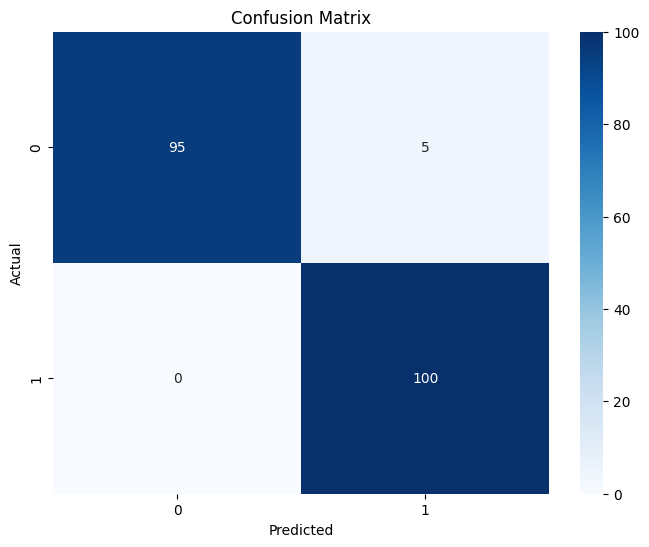

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()